> Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.
>
> -- [Prasad Patil, Novice Data Science Storyteller, Mar 23](https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15)

**Goals of exploration**

- Can we see patterns, find signals in the data? 

- What features are driving the outcome? 

- Are there other feature we can construct that have stronger relationships? 

- Use visualization and statistical testing to help answer these quesitons. 

- We want to walk away with the modeling strategies (feature selection, algorirthm selection, evaluation methods) & knowledge and understanding of what's going on in our data. 

**Agenda**

- Wrangle (acquire, prep, summarize, split)

- ID questions to answer, hypotheses to test

- Answer those

- draw conclusions

**Sample Scenario**

We would like to be able to use attributes of **mall customers** to estimate their spending score.
In doing so, we can target those customers that are likely to be most profitable for us. 
Our target variable is spending_score. 
Currently the only customer data we have available to use in this project is age, annual_income and gender. 
It is possible we may not have enough information to build a valuable model. If not, maybe we could do some unsupervised learning, and find clusters of similar customers using all of the variables (including spending_score) and that could help us with a starting point for our targeted marketing. 

## Wrangle Data

Mall Customer data stored in sql db. 

**Prepare the environment**

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
# from sklearn.model_selection import learning_curve

pd.options.display.float_format = '{:20,.2f}'.format

**Acquire**

Acquire Mall Customer data from our SQL database using the acquire helper function we created. 

Acquire.py: 

```python
import pandas as pd
import env

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def get_mallcustomer_data():
    df = pd.read_sql('SELECT * FROM customers;', get_connection('mall_customers'))
    return df.set_index('customer_id')
```

In [2]:
import acquire

# read the data into df
df = acquire.get_mallcustomer_data()

In [3]:
df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [5]:
# create dummy var with gender, drop the first dummy var. 

df['is_male'] = pd.get_dummies(df['gender'], drop_first=True)['Male']
df.drop(columns=['gender'], inplace=True)
df.head()

,age,annual_income,spending_score,is_male
customer_id,,,,
1,19,15,39,1
2,21,15,81,1
3,20,16,6,0
4,23,16,77,0
5,31,17,40,0


**Summarize**

Is the data ready to explore? 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             200 non-null    int64
 1   annual_income   200 non-null    int64
 2   spending_score  200 non-null    int64
 3   is_male         200 non-null    uint8
dtypes: int64(3), uint8(1)
memory usage: 6.4 KB


In [7]:
df.describe()

,age,annual_income,spending_score,is_male
count,200.00,200.00,200.00,200.00
mean,38.85,60.56,50.20,0.44
std,13.97,26.26,25.82,0.50
min,18.00,15.00,1.00,0.00
25%,28.75,41.50,34.75,0.00
50%,36.00,61.50,50.00,0.00
75%,49.00,78.00,73.00,1.00
max,70.00,137.00,99.00,1.00


**train validate test split**

In [8]:
# split off test, 20% of original df size

train_validate, test = train_test_split(df, test_size=.20, random_state=42)

# split off validate, 30% of train_validate (24% of original)
train, validate = train_test_split(train_validate, test_size=.30, random_state=42)


In [9]:
print("train obs: ", train.size)
print("validate obs: ", validate.size)
print("test obs: ", test.size)

train obs:  448
validate obs:  192
test obs:  160


*We are not going to explore the scaled data at this time, but it is important that the data is scaled before moving into clustering.*

## Exploratory Analysis

**Target Variable:** spending_score

Questions to answer &/or hypotheses to test: 

1. What is the distribution of each of the variables? This is important as we move forward into testing and modeling. 

1. Does the spending score differ across gender? 

2. Is there a relationship between spending score and annual income? (Linear or otherwise). 

3. Is there a relationship between age and spending score? (Linear or otherwise). 

4. If we control for age (by decade), does spending score differ across annual income? 

5. If we control for annual income, does spending score differ across age decades? 


Tips to remember when visualizing for exploration (as opposed to visualizing for reporting or storytelling): 

- Charts are many and are quickly made.

- Axis and labels are cleaned up later.

- Color and size are used for information, not aesthetics.

- Chart types include box plots, heatmaps, histograms, density plots, and feature or correlation plots.

- Title are useful!

**1.What is the distribution of each of the variables? This is important as we move forward into testing and modeling.**

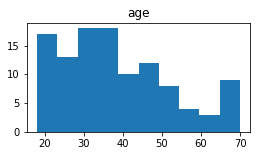

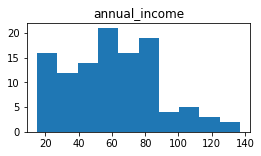

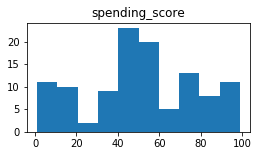

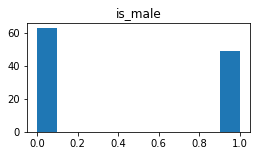

In [10]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

**Conclusion:**

- spending_score is normally distributed

- age and annual income are skewed right. I will want to use spearman's correlation test when testing for a linear relationship due to the skew. 

- The sample has slightly fewer males. 

- If I make bins, I might want to bin 90K for annual income and 50K for age. 

______________________



**2. Does the spending score differ across gender?**

1. plot gender vs spending score
2. 2-sample, 2-tailed t-test comparing the mean spending_score male vs. not male. (i would need to test the assumption of equal variance) 

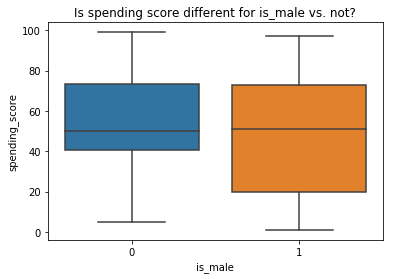

In [13]:
sns.boxplot(train.is_male, train.spending_score)
plt.title("Is spending score different for is_male vs. not?")
plt.show()

In [14]:
# test the equal variance 
# H0 is that the variances are equal
# Levene test

not_male_gp = train[train.is_male==0]
is_male_gp = train[train.is_male==1]

stats.levene(not_male_gp.spending_score, is_male_gp.spending_score)

LeveneResult(statistic=1.52123656007133, pvalue=0.22006154667448222)

In [15]:
stats.ttest_ind(not_male_gp.spending_score, is_male_gp.spending_score, 
                equal_var=True)

Ttest_indResult(statistic=0.7973640087804729, pvalue=0.4269574825618323)

**Conclusion:** No, spending scores do no differ across gender (without the interaction of another variable)

____________________________

**3. Is there a relationship between spending score and annual income? (Linear or otherwise).**

1. plot annual_income by spending_score
2. if there appears to be some linear correlation, then run spearman's test for linear correlation. We would run spearman's instead of pearson's because both variables are not normally distributed (annual_income, in this case). 

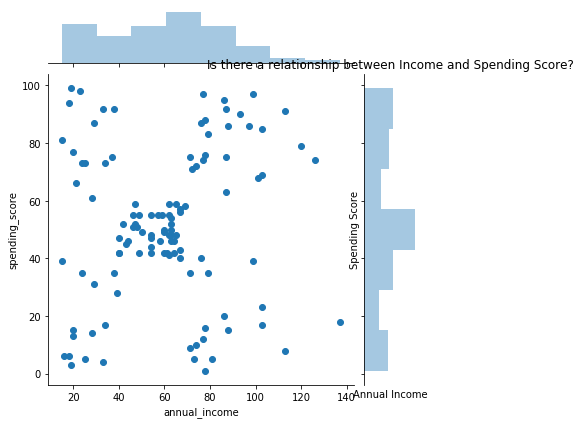

In [16]:
sns.jointplot(x="annual_income", y="spending_score", data=train)
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.title("Is there a relationship between Income and Spending Score?")
plt.show()

**Conclusion:** There is not a linear relationship between annual income and spending score, but there does appear to be some sort of relationship, shaped like an x. There appear to be some clusters. It makes me think that we might be able to distinguish the lows vs highs with another variable, maybe age. 

___________________________________

**4. Is there a relationship between age and spending score? (Linear or otherwise).**

**Plan:**

1. Plot age by spending_score. 
2. Linear Relationship? If there appears to be something, I can run a spearman's test to confirm. (Spearman because age is not normally distributed. If it was, I would use a pearson's test.)
3. Create groups of ages and compare mean spending score using t-test and plotting. 

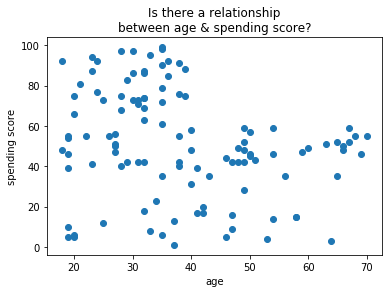

In [17]:
# plot age by spending score

plt.scatter(train.age, train.spending_score)
plt.xlabel("age")
plt.ylabel("spending score")
plt.title("Is there a relationship\nbetween age & spending score?")
plt.show()

It appears that after 40 or so, max spending score drops. (range is limited to < 60 +/-)
If I bin the age \[0, 40\], (40, 80\], will there be a significant difference in spending score? 


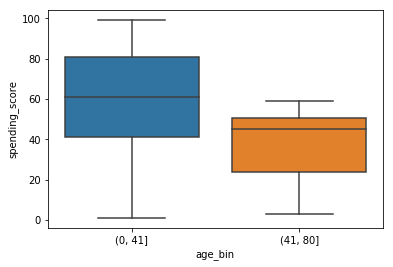

In [19]:
# create age bins
train['age_bin'] = pd.cut(train.age, [0, 41, 80])

# box plot of the two groups & spending score
sns.boxplot(train.age_bin, train.spending_score)

There is definitely a difference between these two groups. 
I will run a two-sample, two-tailed t-test just to confirm the sample sizes aren't leading us to make false assumptions. It is clear the variances between the two groups is different, so I will set the 'equal_var' argument to false. 

In [20]:
train.head()

,age,annual_income,spending_score,is_male,age_bin
customer_id,,,,,
131,47,71,9,1,"(41, 80]"
63,67,47,52,0,"(41, 80]"
14,24,20,77,0,"(0, 41]"
174,36,87,92,1,"(0, 41]"
145,25,77,12,1,"(0, 41]"


In [21]:
# test the assumption of equal variance

stats.levene(train[train.age <= 41].spending_score, 
             train[train.age > 41].spending_score
            )

LeveneResult(statistic=12.770226083616274, pvalue=0.0005242222145990925)

In [22]:
# variances are unequal
# t-test

stats.ttest_ind(train[train.age <= 41].spending_score, 
                train[train.age > 41].spending_score,
                equal_var=False
               )

Ttest_indResult(statistic=4.66070280254923, pvalue=9.072580523237405e-06)

**Conclusion:**
While there is not a linear relationship, there is a significant difference in spending score for ages <= 41 vs those > 41. 
______________________________

**5. If we control for age, does spending score differ across annual income?**

**Plan**

1. Let's start by plotting annual income by spending score for each of the age bins created. 

2. Analyze each bin separately. For those <=41, is there a relationship between income and spending score? For those > 41, is there a relationship? 

3. If a test is necessary, run a test. 

*If we look at the plot that was shaped like an x (income vs spending) with only the customers <= 41, will the shape change?*

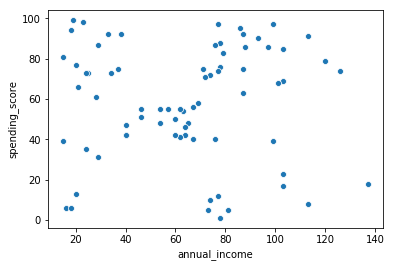

In [25]:
sns.scatterplot(x='annual_income', y='spending_score', 
                data=train[train.age <= 41])

Still maintains the x-shape, maybe a little more on the upper parts of the x. 

Let's look at those > 41. 

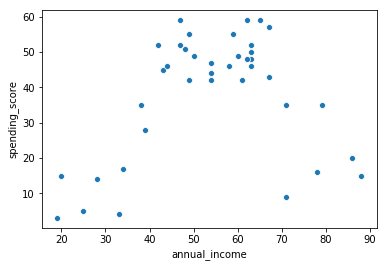

In [26]:
sns.scatterplot(x='annual_income', y='spending_score',
               data=train[train.age > 41])

For those > 41, the shape is a quadratic curve opening down. 
This makes me wonder if we split the 40's into 20's and 30's, will that account for the lower and upper extremes? 

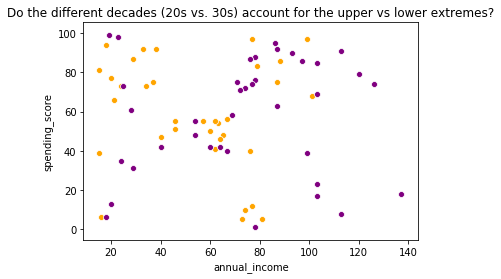

In [32]:
sns.scatterplot(x='annual_income', y='spending_score',
               data=train[train.age<=30], color='orange')
sns.scatterplot(x='annual_income', y='spending_score',
               data=train[(train.age>30) & (train.age<=41)], 
                color='purple')
plt.title("Do the different decades (20s vs. 30s) account for the upper vs lower extremes?")
plt.show()

The different decades do not seem to be driving theh difference. 
It could be gender, or it could be nothing that I currently have that explains that. 

**Conclusion:**

- For those <= 41, annual income and spending score still maintain the shape of the x somewhat, but definitely tending more toward the upper corners. This does not clear up when separating between 20's and 30's.

- For those > 41, they are all sitting on the lower half of the x, making a quadratic shape opening downward.

**5b. Does gender explain the extremes for the group <=41?**

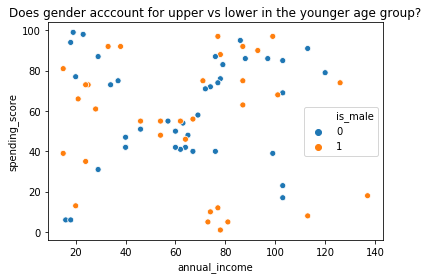

In [34]:
sns.scatterplot(x='annual_income', y='spending_score',
               data=train[train.age <= 41], hue='is_male')

plt.title("Does gender acccount for upper vs lower in the younger age group?")
plt.show()

**Conclusion:** It's possible gender could be the difference here, but I'm not sure if there is enough evidence to conclude that. It appears that non-males under 40 have a quadratic curve that opens up and has a minimum at annual income between 40 and 60. It appears that males under 40 go both up and down on the extremities (still have the x-shape). 

**6. If we control for annual income, does spending score differ across age decades?**

Because of the shape of annual income with spending score, I will create 3 bins of income: \[0, 40), \[40, 70), \[70, 140\].

In [35]:
train['income_bin'] = pd.cut(train.annual_income, [0, 40, 70, 140])

In [36]:
train.head()

,age,annual_income,spending_score,is_male,age_bin,income_bin
customer_id,,,,,,
131,47,71,9,1,"(41, 80]","(70, 140]"
63,67,47,52,0,"(41, 80]","(40, 70]"
14,24,20,77,0,"(0, 41]","(0, 40]"
174,36,87,92,1,"(0, 41]","(70, 140]"
145,25,77,12,1,"(0, 41]","(70, 140]"


In [37]:
inc_low = train[train.annual_income<=40]
inc_mid = train[(train.annual_income>40) & (train.annual_income<=70)]
inc_high = train[train.annual_income>70]


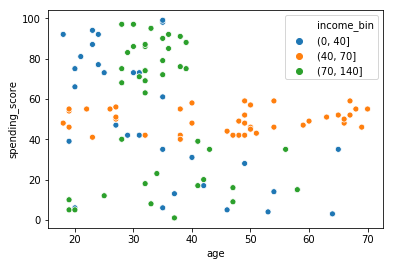

In [38]:
sns.scatterplot(x='age', y='spending_score',
               data=train, hue='income_bin')

In [ ]:
plt.scatter(train.age, train.spending_score)
plt.xlabel("age")
plt.ylabel("spending score")
plt.title("Is there a relationship\nbetween age & spending score?")
plt.show()

**Conclusion:**

There appears to be no difference in spending score for lower income vs. higher income...it appears that all the difference that exists is due to age. 
We could either just do two bins for income (mid vs. high/low) or we could 3 and see what happens. 
Using the binned age as a feature instead of continuous age, and using binned income instead of continuous income. 

**Features**

- maybe try to build clusters with the annual_income
- use the 2 age bins (0,41], (41,)
- Use income bins 
- keep gender to see if it adds value. 

**Other plots**

sns.pairplot()

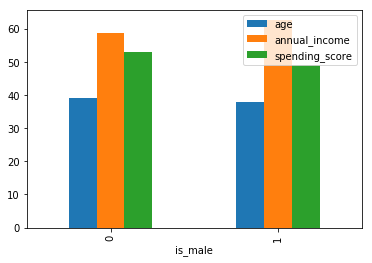

In [40]:
train.groupby('is_male').mean().plot.bar()


## Exercises

**Tips Dataset**

Create either a python script or a jupyter notebook named `explore_tips` that
explores the tips data set that is built in to seaborn. Perform at least 1
t-test and 1 chi square test.

You can load the data set like this:

```
import seaborn as sns

sns.load_dataset('tips')
```

**Zillow Dataset**

Create a python script or jupyter notebook named `explore_zillow` and do the following:

1. Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County? 

1. Answer those questions through a mix of statistical tests and visualizations. 

In your exploration, be sure you include the following:

1. a plot with at least 3 dimensions, such as x, y, and color. 

1. at least 3 different **types** of plots (like box, scatter, bar, ...)

1. at least 2 statistical tests. 

1. document takeaways/conclusions after each question is addressed.  

Bonus:

Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error. 
